**Abstract:** This is dataset that describe Portugal bank marketing campaigns results. Conducted campaigns were based mostly on direct phone calls, offering bank's clients to place a term deposit. If after all marking afforts client had agreed to place deposit - target variable marked 'yes', otherwise 'no'.

Sourse of the data https://archive.ics.uci.edu/ml/datasets/bank+marketing

Dataset description https://www.kaggle.com/volodymyrgavrysh/bank-marketing-campaigns-data-set-description

Citation Request:

This dataset is public available for research. The details are described in S. Moro, P. Cortez and P. Rita. "A Data-Driven Approach to Predict the Success of Bank Telemarketing." Decision Support Systems, Elsevier, 62:22-31, June 2014 <


**Task**

Predicting the future results of marketing companies based on available statistics and, accordingly, formulating recommendations for such companies in the future.
building a profile of a consumer of banking services (deposits).
Approach
The following steps will be performed to complete the task:


*   Loading data and holding a short Expanatory Data Analysis (EDA).
*   Formulating hypotheses regarding individual factors (features) for conducting correct data clearining and data preparation for modeling.
*   The choice of metrics result
*   Building a pipline for Cross Validation and Grid Search procedures (search for optimal parameters of the model)
*   The choice of the most effective model, build learninig curve rate
*   Conclusions and recomendations.



**Feature description**

*Bank client data:*

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

*Related with the last contact of the current campaign:*

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

*other attributes:*

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

*social and economic context attributes*

16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

17 - cons.price.idx: consumer price index - monthly indicator (numeric)

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)

19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):

21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 3.8 MB/s eta 0:00:00


In [26]:
# Import libraries 
import pandas as pd
import numpy as np
import time
import gc
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout
from sklearn.metrics import accuracy_score
import joblib
from keras.callbacks import EarlyStopping

import category_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from tqdm import tqdm

In [ ]:
# Read data
data = pd.read_csv('Deposit_Data.csv', sep=';')
display(data.head(3))
display('There is {} observations with {} features'.format(data.shape[0], data.shape[1]))


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


'There is 41188 observations with 21 features'

## 1. Explore categorical features (EDA)

In [ ]:
# Build a function to show categorical values disribution
def plot_bar(column):
    # temp df 
    temp_1 = pd.DataFrame()
    # count categorical values
    temp_1['No_deposit'] = data[data['y'] == 'no'][column].value_counts()
    temp_1['Yes_deposit'] = data[data['y'] == 'yes'][column].value_counts()
    temp_1.plot(kind='bar')
    plt.xlabel(f'{column}')
    plt.ylabel('Number of clients')
    plt.title('Distribution of {} and deposit'.format(column))
    plt.show();

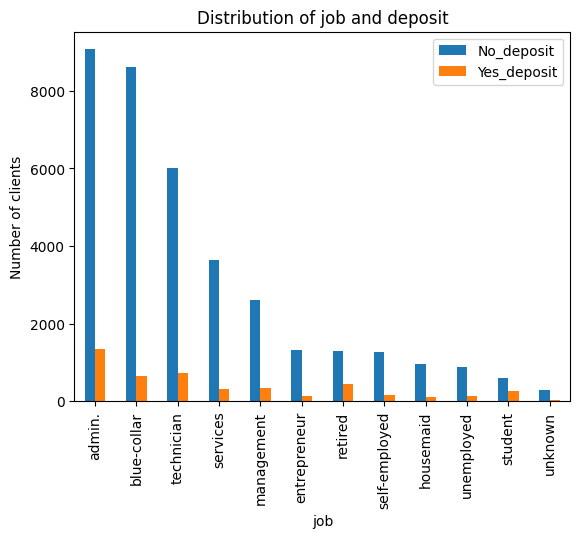

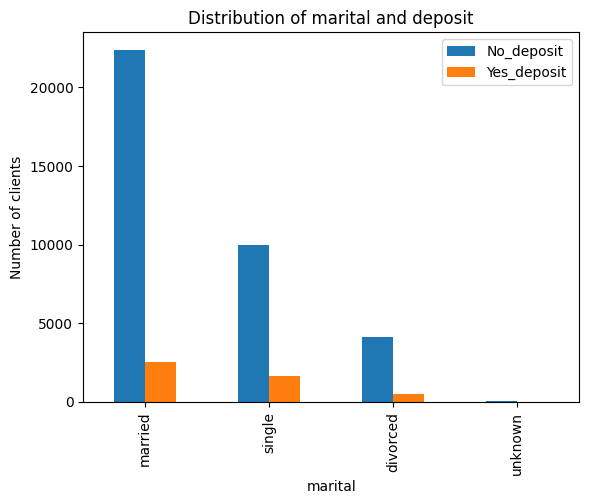

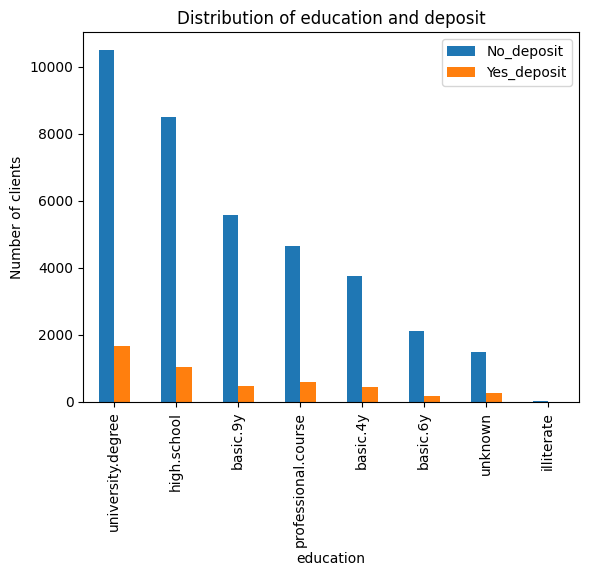

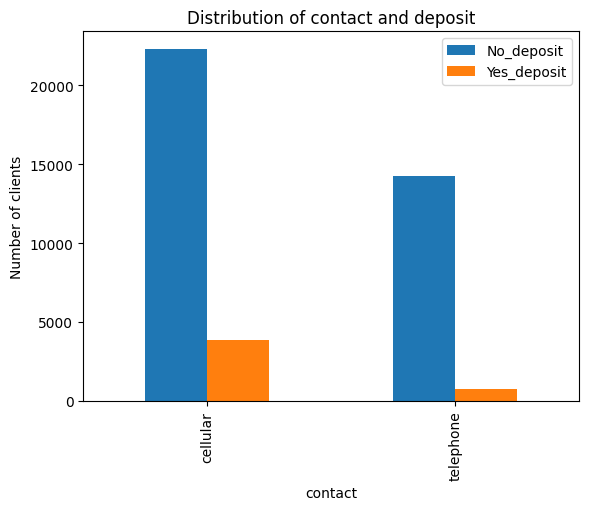

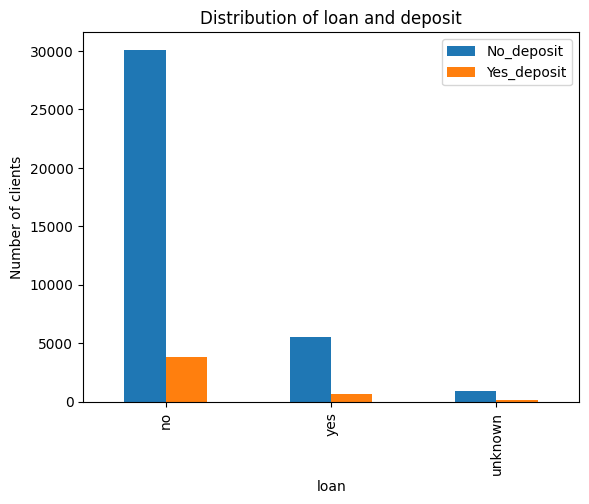

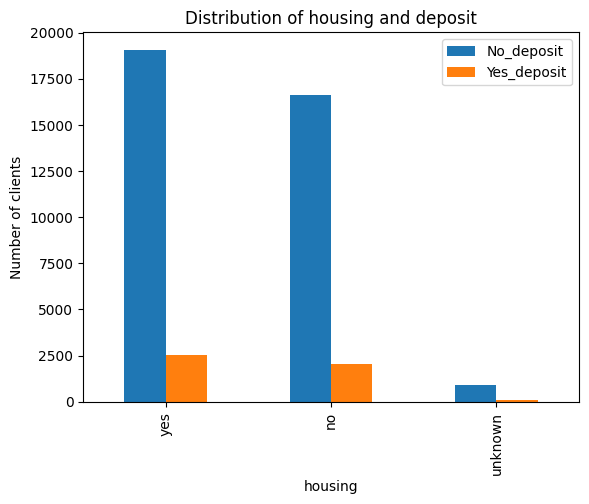

(None, None, None, None, None, None)

In [ ]:
plot_bar('job'), plot_bar('marital'), plot_bar('education'), plot_bar('contact'), plot_bar('loan'), plot_bar('housing')

Primary analysis of several categorical features reveals:

*   Administrative staff and technical specialists opened the deposit most of all. In relative terms, a high proportion of pensioners and students might be mentioned as well.
*   Although in absolute terms married consumers more often agreed to the service, in relative terms the single was responded better.
*   Best communication channel is cellular
*   The difference is evident between consumers who already use the services of banks and received a loan.
*   Home ownership does not greatly affect marketing company performance.





In [ ]:
# Convert target variable into numeric
data.y = data.y.map({'no':0, 'yes':1}).astype('uint8')

In [ ]:
# Build correlation matrix
corr = data.corr()
corr.style.background_gradient(cmap='PuBu')

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.030399
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703,0.405274
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.066357
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.324914
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.230181
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.298334
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.136211
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.054878
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,-0.307771
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,-0.354678


From correlation matrix we observe next:

Higly correlated features (employment rate, consumer confidence index, consumer price index) may describe clients state from different social-economic angles. Their variance might support model capacity for generalization.

## Data Cleaning

Since categorical variables dominate in dataset and the number of weakly correlated numeric variables is not more than 4, we need to transform categorical variables to increase the model's ability to generalize data. (we can not drop them)

Particular attention should be paid to the Duration Feature and categories that can be treated as binary. It suggests using binning and simple transformation accordingly (0 and 1) 

####Note: we are not going to use the duration as it won't me avilable at during production

For categories of more than 3 types of possible option (marital and education) it is proposed to use the encode targeting - it will allow correctly relate the values to the target variable and use indicated categories in numerical form.

In some cases, rescaling is proposed to normalize the data.

In [ ]:
# Replacing values with binary ()
data.contact = data.contact.map({'cellular': 1, 'telephone': 0}).astype('uint8') 
data.loan = data.loan.map({'yes': 1, 'unknown': 0, 'no' : 0}).astype('uint8')
data.housing = data.housing.map({'yes': 1, 'unknown': 0, 'no' : 0}).astype('uint8')
data.default = data.default.map({'no': 1, 'unknown': 0, 'yes': 0}).astype('uint8')
data.pdays = data.pdays.replace(999, 0) # replace with 0 if not contact 
data.previous = data.previous.apply(lambda x: 1 if x > 0 else 0).astype('uint8') # binary has contact or not

# binary if were was an outcome of marketing campane
data.poutcome = data.poutcome.map({'nonexistent':0, 'failure':0, 'success':1}).astype('uint8') 

# change the sign (we want all be positive values)
data['cons.conf.idx'] = data['cons.conf.idx'] * -1

# change the range of Var Rate
data['emp.var.rate'] = data['emp.var.rate'].apply(lambda x: x*-0.0001 if x > 0 else x*1)
data['emp.var.rate'] = data['emp.var.rate'] * -1
data['emp.var.rate'] = data['emp.var.rate'].apply(lambda x: -np.log(x) if x < 1 else np.log(x)).astype('uint8')

# re-scale variables
data['nr.employed'] = np.log2(data['nr.employed']).astype('uint8')

# fucntion to One Hot Encoding
def encode(data, col):
    return pd.concat([data, pd.get_dummies(col, prefix=col.name)], axis=1)

# One Hot encoding of 3 variable 
data = encode(data, data.job)
data = encode(data, data.month)
data = encode(data, data.day_of_week)


# Column keep
data['cons.price.idx'] = (data['cons.price.idx']).astype('uint8')
data.euribor3m = data.euribor3m.astype('uint8')
data.campaign = data.campaign.astype('uint8')
data.age = data.age.astype('uint8')


# Drop tranfromed and un-necessary features
data.drop(['job', 'month', 'day_of_week','duration'], axis=1, inplace=True)

In [ ]:
''' Target encoding for two categorical feature '''
# save target variable before transformation
y = data.y
# Create target encoder object and transoform two value
target_encode = ce.target_encoder.TargetEncoder(cols=['marital', 'education']).fit(data, y)
numeric_dataset = target_encode.transform(data)
# drop target variable
numeric_dataset.drop('y', axis=1, inplace=True)

In [21]:
'''Check numerical data set'''
display(numeric_dataset.head(3), numeric_dataset.shape, y.shape)
display('We observe 41175 rows and 44 numerical features after transformation. Target variable shape is (41175, 0 ) as expected')

,age,marital,education,default,housing,loan,contact,campaign,pdays,previous,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,56,0.101573,0.102490,1,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
1,57,0.101573,0.108355,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
2,37,0.101573,0.108355,1,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0


(41188, 43)

(41188,)

'We observe 41175 rows and 44 numerical features after transformation. Target variable shape is (41175, 0 ) as expected'

### Modeling

In [22]:
''' Split data on train and test'''
# set global random state
random_state = 11
# split data
X_train, X_test, y_train, y_test = train_test_split(numeric_dataset, y, test_size=0.2, random_state=random_state)
# collect excess data
gc.collect()

27547

In [23]:
num_features=X_train.shape[1]

def create_nn(activation='relu', optimizer='adam', dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(10, input_dim=num_features, activation=activation.lower()))
    model.add(Dense(16,activation='tanh'))
    #model.add(Dense(8,activation='relu',kernel_regularizer='l2'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [24]:
display('check the shape of splitted train and test sets', X_train.shape, y_train.shape, X_test.shape, y_test.shape)

'check the shape of splitted train and test sets'

(32950, 43)

(32950,)

(8238, 43)

(8238,)

In [27]:
'''Build pipline of classifiers'''
# set all CPU
n_jobs = -1
# LogisticRegression
pipe_lr = Pipeline([('lr', LogisticRegression(random_state=random_state, n_jobs=n_jobs, max_iter=500))])
# RandomForestClassifier
pipe_rf = Pipeline([('rf', RandomForestClassifier(random_state=random_state, oob_score=True, n_jobs=n_jobs))])
# KNeighborsClassifier
pipe_knn = Pipeline([('knn', KNeighborsClassifier(n_jobs=n_jobs))])
# DecisionTreeClassifier
pipe_dt = Pipeline([('dt', DecisionTreeClassifier(random_state=random_state, max_features='auto'))])
# BaggingClassifier
# note we use SGDClassifier as classier inside BaggingClassifier
pipe_bag = Pipeline([('bag',BaggingClassifier(base_estimator=SGDClassifier(random_state=random_state, n_jobs=n_jobs, max_iter=1500),\
                                              random_state=random_state,oob_score=True,n_jobs=n_jobs))])
# SGDClassifier
pipe_sgd = Pipeline([('sgd', SGDClassifier(random_state=random_state, n_jobs=n_jobs, max_iter=1500))])
#XgboostClassifier
pipe_xgb = Pipeline([('xgb',XGBClassifier())])

pipe_nn = Pipeline([('NN', KerasClassifier(build_fn=create_nn, activation='relu',callbacks=[EarlyStopping(monitor='accuracy', patience=3)] )    )])

In [28]:
'''Set parameters for Grid Search '''
# set number 
cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=random_state)
# set for LogisticRegression
grid_params_lr = [{
                'lr__penalty': ['l2'],
                'lr__C': [0.3, 0.6, 0.7],
                'lr__solver': ['sag']
                }]
# set for RandomForestClassifier
grid_params_rf = [{
                'rf__criterion': ['entropy'],
                'rf__min_samples_leaf': [80, 100],
                'rf__max_depth': [25, 27],
                'rf__min_samples_split': [3, 5],
                'rf__n_estimators' : [60, 70]
                }]
# set for KNeighborsClassifier
grid_params_knn = [{'knn__n_neighbors': [16,17,18]}]

# set for DecisionTreeClassifier
grid_params_dt = [{
                'dt__max_depth': [8, 10],
                'dt__min_samples_leaf': [1, 3, 5, 7]
                  }]
# set for BaggingClassifier
grid_params_bag = [{'bag__n_estimators': [10, 15, 20]}]

# set for SGDClassifier
grid_params_sgd = [{
                    'sgd__loss': ['log', 'huber'],
                    'sgd__learning_rate': ['adaptive'],
                    'sgd__eta0': [0.001, 0.01, 0.1],
                    'sgd__penalty': ['l1', 'l2', 'elasticnet'], 
                    'sgd__alpha':[0.1, 1, 5, 10]
                    }]
#set for XGBClassifier
grid_params_xgb = [{
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.1, 0.01, 0.001],
    'xgb__n_estimators': [50, 100, 200],
    'xgb__gamma': [0, 0.1, 0.5]
}]

#set for Neural net
grid_params_nn = [{
                   'NN__batch_size': [32,64,128,256],
                   'NN__epochs': [2,4,8],
                   'NN__optimizer': ['adam', 'rmsprop'],
                   'NN__activation': ['relu', 'sigmoid']
}]


In [29]:
'''Grid search objects'''
# for LogisticRegression
gs_lr = GridSearchCV(pipe_lr, param_grid=grid_params_lr,
                     scoring='accuracy', cv=cv) 
# for RandomForestClassifier
gs_rf = GridSearchCV(pipe_rf, param_grid=grid_params_rf,
                     scoring='accuracy', cv=cv)
# for KNeighborsClassifier
gs_knn = GridSearchCV(pipe_knn, param_grid=grid_params_knn,
                     scoring='accuracy', cv=cv)
# for DecisionTreeClassifier
gs_dt = GridSearchCV(pipe_dt, param_grid=grid_params_dt,
                     scoring='accuracy', cv=cv)
# for BaggingClassifier
gs_bag = GridSearchCV(pipe_bag, param_grid=grid_params_bag,
                     scoring='accuracy', cv=cv)
# for SGDClassifier
gs_sgd = GridSearchCV(pipe_sgd, param_grid=grid_params_sgd,
                     scoring='accuracy', cv=cv)

# for XGBClassifier
gs_xgb = GridSearchCV(pipe_xgb, param_grid=grid_params_xgb,
                     scoring='accuracy', cv=cv)
# for NeuralNet
gs_nn = GridSearchCV(pipe_nn, param_grid=grid_params_nn,
                     scoring='accuracy', cv=cv)

In [30]:
# models that we iterate over
look_for = [gs_lr, gs_rf, gs_knn, gs_dt, gs_bag, gs_sgd,gs_xgb,gs_nn]
# dict for later use 
model_dict = {0:'Logistic_reg', 1:'RandomForest', 2:'Knn', 3:'DesionTree', 4:'Bagging with SGDClassifier', 5:'SGD Class', 6:'XGB Classifier',7:"Neural Network"}

In [31]:
''' Function to iterate over models and obtain results'''
# set empty dicts and list
result_acc = {}
result_auc = {}
models = []

for index, model in enumerate(look_for):
        start = time.time()
        print()
        print('+++++++ Start New Model ++++++++++++++++++++++')
        print('Estimator is {}'.format(model_dict[index]))
        model.fit(X_train, y_train)
        print('---------------------------------------------')
        print('best params {}'.format(model.best_params_))
        print('best score is {}'.format(model.best_score_))
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        print('---------------------------------------------')
        print('ROC_AUC is {} and accuracy rate is {}'.format(auc, model.score(X_test, y_test)))
        end = time.time()
        print('It lasted for {} sec'.format(round(end - start, 3)))
        print('++++++++ End Model +++++++++++++++++++++++++++')
        print()
        print()
        models.append(model.best_estimator_)
        result_acc[index] = model.best_score_
        result_auc[index] = auc


+++++++ Start New Model ++++++++++++++++++++++
Estimator is Logistic_reg
---------------------------------------------
best params {'lr__C': 0.7, 'lr__penalty': 'l2', 'lr__solver': 'sag'}
best score is 0.89793626707132
---------------------------------------------
ROC_AUC is 0.7922900458125489 and accuracy rate is 0.902282107307599
It lasted for 225.938 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is RandomForest
---------------------------------------------
best params {'rf__criterion': 'entropy', 'rf__max_depth': 25, 'rf__min_samples_leaf': 80, 'rf__min_samples_split': 3, 'rf__n_estimators': 70}
best score is 0.8987860394537177
---------------------------------------------
ROC_AUC is 0.8040964166832577 and accuracy rate is 0.9024034959941734
It lasted for 129.608 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is Knn
---------------------------------------

Choice of the most effective model, build learninig curve rate

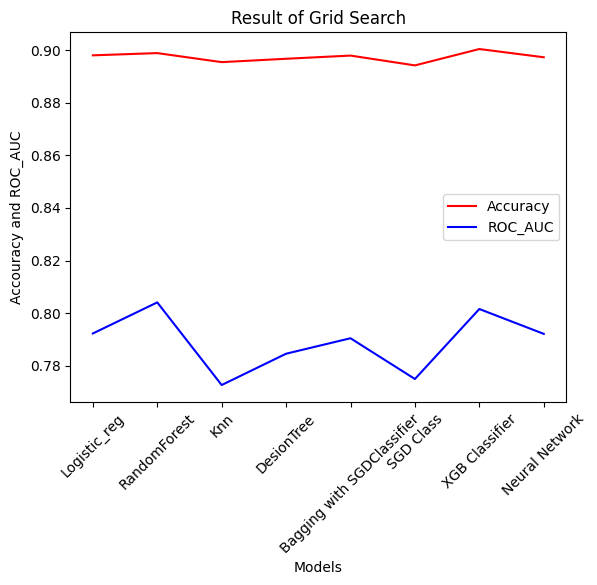

In [32]:
plt.plot(model_dict.values(), result_acc.values(), c='r')
plt.plot(model_dict.values(), result_auc.values(), c='b')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.ylabel('Accouracy and ROC_AUC')
plt.title('Result of Grid Search')
plt.legend(['Accuracy', 'ROC_AUC'])
plt.show();

In [33]:
""" Model performance during Grid Search """
pd.DataFrame(list(zip(model_dict.values(), result_acc.values(), result_auc.values())),columns=['Model', 'Accuracy_rate','Roc_auc_rate'])

,Model,Accuracy_rate,Roc_auc_rate
0,Logistic_reg,0.897936,0.792290
1,RandomForest,0.898786,0.804096
2,Knn,0.895357,0.772709
3,DesionTree,0.896631,0.784601
4,Bagging with SGDClassifier,0.897845,0.790480
5,SGD Class,0.894112,0.774996
6,XGB Classifier,0.900334,0.801580
7,Neural Network,0.897208,0.792141


**Best model**

Our best performed model with ROC_AUC (0.80) metric is XGBoost . This classifier could achive accuracy rate 0.900334 that is average accuracy among all classifiers.


In [42]:
models[6]

Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [38]:
models[6]

Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [39]:
''' Build graph for ROC_AUC '''

fpr, tpr, threshold = roc_curve(y_test, models[6].predict_proba(X_test)[:,1])
                                        
trace0 = go.Scatter(
    x=fpr,
    y=tpr,
    text=threshold,
    fill='tozeroy',
    name='ROC Curve')

trace1 = go.Scatter(
    x=[0,1],
    y=[0,1],
    line={'color': 'red', 'width': 1, 'dash': 'dash'},
    name='Baseline')

data = [trace0, trace1]

layout = go.Layout(
    title='ROC Curve',
    xaxis={'title': 'False Positive Rate'},
    yaxis={'title': 'True Positive Rate'})

fig = go.Figure(data, layout)
fig.show();

Curve is well distributed with tendency to False Positive Rate. The roc auc values of the best model of 0.81 is quite high level to make later assumptions about the data.

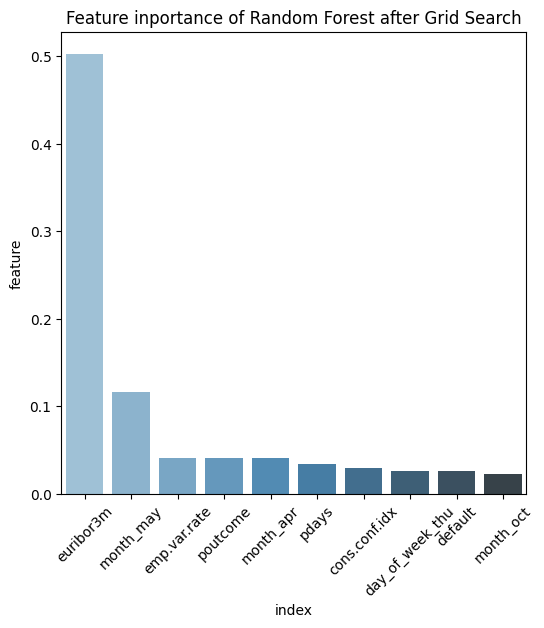

In [43]:
''' Build bar plot of feature importance of the best model '''

def build_feature_importance(model, X_train, y_train):

    models = XGBClassifier(gamma=0, learning_rate=0.01, max_depth=5,n_estimators=200)
    models.fit(X_train, y_train)
    data = pd.DataFrame(models.feature_importances_, X_train.columns, columns=["feature"])
    data = data.sort_values(by='feature', ascending=False).reset_index()
    plt.figure(figsize=[6,6])
    sns.barplot(x='index', y='feature', data=data[:10], palette="Blues_d")
    plt.title('Feature inportance of Random Forest after Grid Search')
    plt.xticks(rotation=45)
    plt.show();
    
build_feature_importance(XGBClassifier, X_train, y_train)

 **Conclusions and recomendations**

What general recommendations can be offered for a successful marketing company in the future?

This analysis can be carried out at the level of individual bank branches as does not require much resources and special knowledge (the model itself can be launched automatically with a certain periodicity).

Potentially similar micro-targeting will increase the overall effectiveness of the entire marketing company.

1. Take into account the time of the company (April is the most effective, And Thursday is right time).
2. Also previous contacted the customer play a critical role.

Focus on specific categories. The model shows that students and senior citizens respond better to proposal.

It is imperative to form target groups based on socio-economic categories. Age, income level (not always high), profession can accurately determine the marketing profile of a potential client.

Given these factors, it is recommended to concentrate on those consumer groups that are potentially more promising.

The continuation of such a study may be the formation of a clear customer profile - by age, gender, income and other factors, as well as the adaptation of the product itself (deposit) for a specific category of consumer.

Thank you for your time!